In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time

glider = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1]
])

blinker = np.array([
    [1, 1, 1]
])

toad = np.array([
    [0, 1, 1, 1],
    [1, 1, 1, 0]
])

block = np.array([
    [1, 1],
    [1, 1]
])

def evolve(field):
    size = field.shape[0]
    next_field = np.zeros_like(field)

    for i in range(1, size - 1):
        for j in range(1, size - 1):
            neighbors = np.sum(field[i-1:i+2, j-1:j+2]) - field[i, j]
            if field[i, j] == 1:
                next_field[i, j] = 1 if neighbors in [2, 3] else 0
            else:
                next_field[i, j] = 1 if neighbors == 3 else 0

    return next_field

In [29]:
from scipy.spatial.distance import euclidean

class Sensor:
    def __init__(self, center_x, center_y, window=10):
        self.cx = center_x
        self.cy = center_y
        self.window = window
        self.log = []
        self.memory = None  # <- NEW

    def observe(self, field):
        x1 = self.cx - self.window
        x2 = self.cx + self.window
        y1 = self.cy - self.window
        y2 = self.cy + self.window

        patch = field[x1:x2, y1:y2]
        alive = np.sum(patch)
        self.log.append(alive)

    def compress_memory(self):
        # Simple compression: use entire log as raw memory
        self.memory = np.array(self.log)

    def compare_with(self, other_sensor):
        if self.memory is None or other_sensor.memory is None:
            print("Memory not yet compressed.")
            return None
        return euclidean(self.memory, other_sensor.memory)


In [30]:
def insert_seed(field, seed, x, y):
    sx, sy = seed.shape
    field[x:x+sx, y:y+sy] = seed

In [31]:
size = 100
field = np.zeros((size, size), dtype=int)

# Add known structures near sensors
insert_seed(field, glider, 20, 20)
insert_seed(field, toad, 50, 50)
insert_seed(field, block, 80, 80)

In [32]:
from matplotlib import animation
from IPython.display import HTML

def simulate_live(field, steps=100, interval=200, zoom_center=None, window=20):
    fig, ax = plt.subplots()

    if zoom_center:
        cx, cy = zoom_center
        def get_zoomed_frame(data):
            return data[cx-window:cx+window, cy-window:cy+window]
    else:
        get_zoomed_frame = lambda data: data

    img = ax.imshow(get_zoomed_frame(field), cmap='binary', interpolation='nearest')
    ax.axis('off')

    def update(step):
        nonlocal field
        field = evolve(field)
        img.set_data(get_zoomed_frame(field))
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=steps, interval=interval, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())


In [33]:
field = np.zeros((100, 100), dtype=int)
insert_seed(field, glider, 20, 20)
insert_seed(field, toad, 50, 50)
insert_seed(field, block, 80, 80)

sensors = [
    Sensor(20, 20, window=10),
    Sensor(50, 50, window=10),
    Sensor(80, 80, window=10)
]

steps = 100
for step in range(steps):
    for s in sensors:
        s.observe(field)
    field = evolve(field)

simulate_live(field.copy(), steps=100)


In [34]:
for s in sensors:
    s.compress_memory()

d_1_2 = sensors[0].compare_with(sensors[1])
d_1_3 = sensors[0].compare_with(sensors[2])
d_2_3 = sensors[1].compare_with(sensors[2])

print(f"Sensor 1 vs 2: {d_1_2:.2f}")
print(f"Sensor 1 vs 3: {d_1_3:.2f}")
print(f"Sensor 2 vs 3: {d_2_3:.2f}")


Sensor 1 vs 2: 67.31
Sensor 1 vs 3: 33.18
Sensor 2 vs 3: 38.38


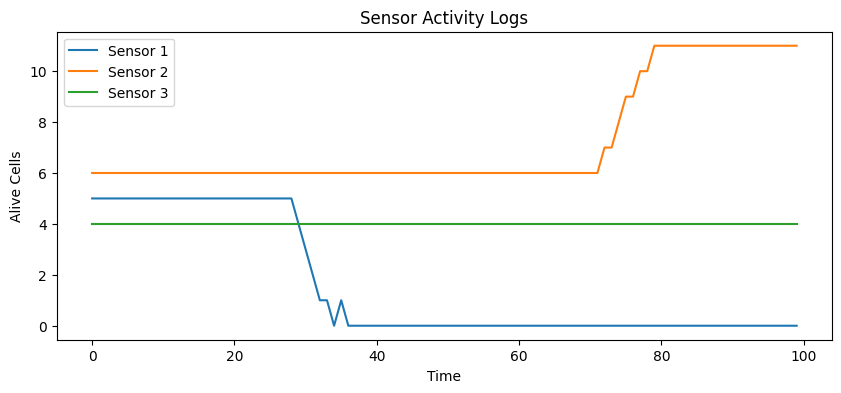

In [35]:
plt.figure(figsize=(10, 4))
for i, s in enumerate(sensors):
    plt.plot(s.log, label=f"Sensor {i+1}")
plt.legend()
plt.title("Sensor Activity Logs")
plt.xlabel("Time")
plt.ylabel("Alive Cells")
plt.show()


⚠️ Injecting Chaos at step 50


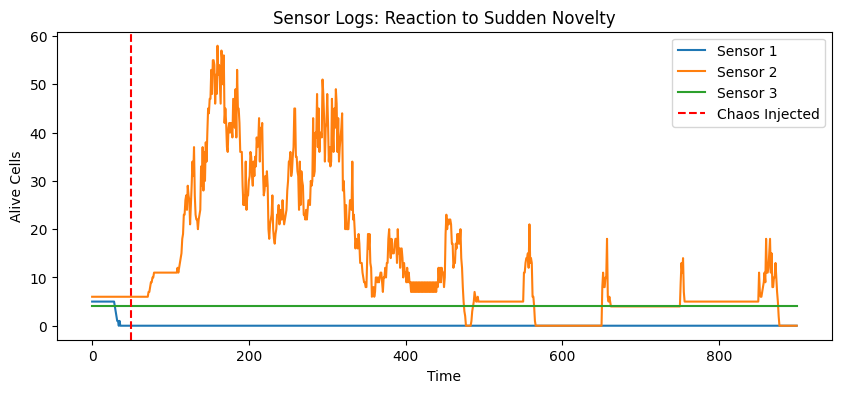

In [44]:
steps = 100
inject_at = 50

for step in range(steps):
    for s in sensors:
        s.observe(field)

    if step == inject_at:
        print("⚠️ Injecting Chaos at step 50")
        insert_seed(field, np.random.randint(0, 2, size=(5,5)), 40, 40)  # chaotic burst

    field = evolve(field)

plt.figure(figsize=(10, 4))
for i, s in enumerate(sensors):
    plt.plot(s.log, label=f"Sensor {i+1}")
plt.axvline(x=inject_at, color='red', linestyle='--', label='Chaos Injected')
plt.legend()
plt.title("Sensor Logs: Reaction to Sudden Novelty")
plt.xlabel("Time")
plt.ylabel("Alive Cells")
plt.show()
